# Standard Hartigan's algorithm

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
class Hartigan:
    """
    Perform k-means clustering using standard Hartigan's algorithm.
    """
    
    def __init__(self):
        self.data = None
        self.centroids = None
        self.y_pred = None
    
    
    def fit(self, data : pd.DataFrame, k : int, seed : int = None, debug=False):
        """
        Fit the model to the data.

        Parameters
        ----------
        data : pd.DataFrame
            nxd DataFrame of n samples with d features
        k : int
            Number of clusters
        seed : int
            Seed for random generator

        Returns
        -------
        np.ndarray
            Array of shape (k, d) with cluster centroids
        np.ndarray
            Array of length n with cluster assignments for each sample
        """

        assert isinstance(data, pd.DataFrame), "data must be a pandas DataFrame"
        assert isinstance(k, int), "k must be an int"
        assert k <= len(data), "k must be at most the number of samples"

        # reset index to be 0-indexed
        data.reset_index(drop=True, inplace=True)
        self.data = data

        np.random.seed(seed)

        # sample initial centroids. While samples at random until we get k different clusters
        closest_points_ids = np.random.choice(k, len(data.index))
        while len(set(closest_points_ids)) != k:
            closest_points_ids = np.random.choice(k, len(data.index))

        self.y_pred = closest_points_ids
        debug and print('init assignment:', closest_points_ids)

        centroids = self._init_centroids(k)
        debug and print('init centroids:\n', centroids)
        self.centroids = centroids

        # start with unsafe mode
        safe_mode = False

        while True:
            # create an empty dictionary of new candidates
            candidates = {}

            print('self.centrodis:', self.centroids)
            print('self.y_pred:', self.y_pred)
            # store current state for possible rollback
            rollback = closest_points_ids.copy()

            for datapoint in data.index:
                
                # calculate cost of current assignment which remains invariant
                current_centroid_id = closest_points_ids[datapoint]
                cluster_size = len(np.where(closest_points_ids == current_centroid_id)[0])
                prefactor = cluster_size / (cluster_size - 1) if cluster_size > 1 else 0
                
                current_cost = prefactor * self._distance(data.loc[datapoint, :], centroids.loc[current_centroid_id, :])

                debug and print('current_cost:', current_cost)

                # iterate only on possible new centroid assignments
                for centroid_id in np.setdiff1d(centroids.index, current_centroid_id):
                    delta_cost = self._delta_cost(current_cost, datapoint, centroid_id)
                    debug and print(f'calculating delta_cost for datapoint {datapoint} from centroid {current_centroid_id} to centroid {centroid_id}')
                    debug and print('delta_cost:', delta_cost)

                    # datapoint is a candidate if it reduces the cost
                    # if more reassignments reduce the cost, the best one is stored (the one producing the most negfative delta_cost)
                    if delta_cost < 0 and (candidates.get(datapoint) is None or delta_cost < candidates[datapoint][0]):
                        candidates[datapoint] = [delta_cost, current_centroid_id, centroid_id]

            debug and print('candidates:', candidates)
            
            # break at convergence
            if not candidates:      ## [] -> False
                debug and print('no more candidates')
                break    

            # proceed in unsafe mode
            if not safe_mode:
                debug and print('entered in unsafe mode')

                original_cost = self._tot_cluster_cost(centroids, closest_points_ids, debug=debug)
                debug and print('original_cost:', original_cost)

                # accept all candidates
                for candidate in candidates.keys():
                    print('candidate:', candidate)
                    
                    [delta_cost, current_centroid_id, new_centroid_id] = candidates[candidate]

                    debug and print('closest_points_ids before:', closest_points_ids)
                    # update closest_points_ids assigning datapoint to new_centroid_id
                    closest_points_ids[candidate] = new_centroid_id
                    debug and print('closest_points_ids after:', closest_points_ids)

                temp_centroids = self._move_centroids(centroids.index)

                if self._tot_cluster_cost(temp_centroids, closest_points_ids, debug=debug) >= original_cost:
                    # new clustering is more expensive, proceed in safe mode
                    safe_mode = True
                    closest_points_ids = rollback
                else:
                    new_centroids = temp_centroids

            # start new condition since safe mode can be entered from unsafe mode
            if safe_mode:
                debug and print('entered in safe mode')

                unchanged_clusters = list(centroids.index)
                for _, [delta_cost, current_centroid_id, new_centroid_id] in sorted(candidates.items(), key=lambda e: e[1][1]):

                    # if both clusters are still unchanged, accept the candidate
                    if current_centroid_id in unchanged_clusters and new_centroid_id in unchanged_clusters:
                        closest_points_ids[datapoint] = new_centroid_id
                        unchanged_clusters.remove(current_centroid_id)
                        unchanged_clusters.remove(new_centroid_id)

                    # if we cannot operate on any more clusters, break
                    if not unchanged_clusters:
                        break

            self.y_pred = closest_points_ids
            new_centroids = self._move_centroids(centroids.index)
            self.centroids = new_centroids

        return centroids, closest_points_ids

    def _init_centroids(self, k):
        """
        Initialize centroids based on random assignment of datapoints
        """
        centroids = pd.DataFrame(index=range(k), columns=self.data.columns)
        for centroid_id in centroids.index:
            cluster_points = self.data.loc[np.where(self.y_pred == centroid_id)[0], :]
            centroids.loc[centroid_id, :] = cluster_points.mean()

        return centroids

    def _move_centroids(self, centroid_ids):
        """
        Move centroids to the baricenter of their assigned points
        """
        centroids = self.centroids.copy()
        for centroid_id in centroid_ids:
            centroids.loc[centroid_id, :] = np.mean(self.data.loc[np.where(self.y_pred == centroid_id)[0], :])

        return centroids

    def _distance(self, x1, x2):
        """
        Compute the squared Euclidean distance between two points
        """
        return np.square(np.linalg.norm(x1-x2))

    def _delta_cost(self, cost, datapoint_id, centroid_id):
        """
        Compute the change in cost if datapoint is reassigned to centroid_id
        """
        cluster_size = len(np.where(self.y_pred == centroid_id)[0])
        prefactor = cluster_size / (cluster_size + 1)

        # cost of new assignment
        new_cost = prefactor * self._distance(self.data.loc[datapoint_id, :], self.centroids.loc[centroid_id, :])

        return new_cost - cost

    def _tot_cluster_cost(self, centroids, points_ids, debug=False):
        """
        Compute the overall cost of clustering
        """
        debug and print('inside _tot_cluster_cost')
        
        partial_sum = []
        for centroid_id in centroids.index:
            cluster_items = np.where(points_ids == centroid_id)[0]
            partial_sum.append(np.sum(np.square(self.data.loc[cluster_items, :] - centroids.loc[centroid_id, :])))

            debug and print('| centroid_id:', centroid_id)
            debug and print('| centroid:\n', centroids.loc[centroid_id, :])
            debug and print('| cluster_items:', cluster_items)
            debug and print('| partial_sum:', partial_sum)
        
        debug and print('_tot_cluster_cost:', np.sum(partial_sum))

        return np.sum(partial_sum)

In [27]:
def accuracy(y_true : np.ndarray, y_pred : np.ndarray):
    """
    Compute the accuracy of the clustering.
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels of the samples
    y_pred : np.ndarray
        Predicted labels of the samples
    
    Returns
    -------
    float
        Accuracy of the clustering through Hungarian algorithm
    """
    
    assert isinstance(y_true, np.ndarray), "y_true must be a numpy array"
    assert isinstance(y_pred, np.ndarray), "y_pred must be a numpy array"

    # create C matrix
    n_classes = max(max(y_true), max(y_pred)) + 1
    C = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        C[true_label, pred_label] += 1
    
    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(-C)
    
    # Calculate accuracy
    matched = C[row_ind, col_ind].sum(axis=0)
    accuracy = matched / len(y_true)
    return accuracy


#### some tests

In [28]:
data = pd.DataFrame([[0,0],[1,1],[20,20],[21,21]])

k_means = Hartigan()
centroids, y_pred = k_means.fit(data, 2, debug=True)

init assignment: [0 0 1 1]
init centroids:
       0     1
0   0.5   0.5
1  20.5  20.5
self.centrodis:       0     1
0   0.5   0.5
1  20.5  20.5
self.y_pred: [0 0 1 1]
current_cost: 1.0000000000000002
calculating delta_cost for datapoint 0 from centroid 0 to centroid 1
delta_cost: 559.3333333333333
current_cost: 1.0000000000000002
calculating delta_cost for datapoint 1 from centroid 0 to centroid 1
delta_cost: 505.9999999999999
current_cost: 1.0000000000000002
calculating delta_cost for datapoint 2 from centroid 1 to centroid 0
delta_cost: 505.9999999999999
current_cost: 1.0000000000000002
calculating delta_cost for datapoint 3 from centroid 1 to centroid 0
delta_cost: 559.3333333333333
candidates: {}
no more candidates


In [29]:
accuracy(y_pred, np.array([0,0,1,1]))

np.float64(1.0)

In [425]:
def generate_test_dataframe(n_clusters=3, n_samples=150, n_features=2, seed=None):
    if seed:
        np.random.seed(seed)
    
    # Calculate points per cluster
    points_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters  # To handle uneven division
    
    data = []
    labels = []
    
    for cluster_id in range(n_clusters):
        # Generate random cluster center
        center = np.random.uniform(-10, 10, size=n_features)
        
        # Generate points for this cluster
        n_points = points_per_cluster + (1 if cluster_id < remainder else 0)
        points = np.random.normal(loc=center, scale=1.0, size=(n_points, n_features))
        
        data.append(points)
        labels.extend([cluster_id] * n_points)
    
    # Combine all clusters into one dataset
    data = np.vstack(data)
    labels = np.array(labels)
    
    # Shuffle the dataset
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # Create a DataFrame
    column_names = [f"Feature{i+1}" for i in range(n_features)]
    df = pd.DataFrame(data, columns=column_names)
    df["Label"] = labels
    
    return df

test_df = generate_test_dataframe(10, 1000, 10, seed=42)

k_means = Hartigan()
k_means.fit(test_df.iloc[:, :-1], 10, seed=42, debug=True)

print('Accuracy:', accuracy(np.array(test_df["Label"]), k_means.y_pred))

init assignment: [6 3 7 4 6 9 2 6 7 4 3 7 7 2 5 4 1 7 5 1 4 0 9 5 8 0 9 2 6 3 8 2 4 2 6 4 8
 6 1 3 8 1 9 8 9 4 1 3 6 7 2 0 3 1 7 3 1 5 5 9 3 5 1 9 1 9 3 7 6 8 7 4 1 4
 7 9 8 8 0 8 6 8 7 0 7 7 2 0 7 2 2 0 4 9 6 9 8 6 8 7 1 0 6 6 7 4 2 7 5 2 0
 2 4 2 0 4 9 6 6 8 9 9 2 6 0 3 3 4 6 6 3 6 2 5 1 9 8 4 5 3 9 6 8 6 0 0 8 8
 3 8 2 6 5 7 8 4 0 2 9 7 5 7 8 3 0 0 9 3 6 1 2 0 4 0 7 0 0 1 1 5 6 4 0 0 2
 1 4 9 5 6 3 6 7 0 5 7 4 3 1 5 5 0 8 5 2 3 3 2 9 2 2 3 6 3 8 0 7 6 1 7 0 8
 8 1 6 9 2 6 9 8 3 0 1 0 4 4 6 8 8 2 2 2 3 7 5 7 0 7 3 0 7 3 5 7 3 2 8 2 8
 1 1 1 5 2 8 3 0 3 0 4 3 7 7 6 2 0 0 2 5 6 5 5 5 2 5 7 1 4 0 0 4 2 3 2 0 0
 4 5 2 8 4 7 0 4 2 0 3 4 6 0 2 1 8 9 5 9 2 7 7 1 5 6 1 9 1 9 0 7 0 8 5 6 9
 6 9 2 1 8 7 9 6 8 3 3 0 7 2 6 1 1 6 5 2 8 9 5 9 9 5 0 3 9 5 5 4 0 7 4 4 6
 3 5 3 2 6 7 3 1 9 2 0 7 2 9 6 9 4 9 4 6 8 4 0 9 9 0 1 5 8 7 4 0 6 4 5 6 2
 9 2 4 5 8 4 0 3 4 9 9 4 6 3 0 4 6 9 9 5 4 3 1 3 9 9 2 9 0 7 4 3 7 6 1 0 3
 7 1 2 0 0 2 4 2 0 0 7 9 1 2 1 2 6 0 9 7 9 9 9 1 2 8 6 3 9 4 1 7 3 8 4 8 3
 9 4 8 7

KeyboardInterrupt: 

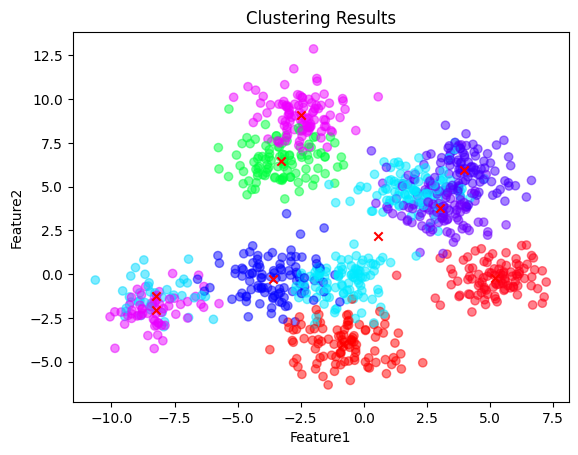

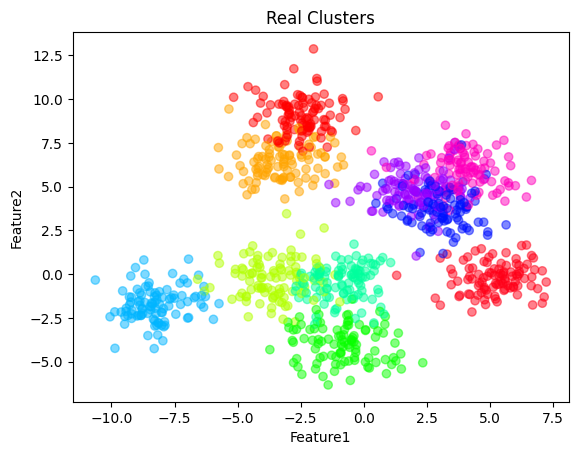

In [41]:
# Plot the data points for two features
plt.scatter(test_df.iloc[:, 0], test_df.iloc[:, 1], cmap='hsv', c=k_means.y_pred, marker='o', alpha=0.5)

# Plot the centroids
plt.scatter(k_means.centroids.iloc[:, 0], k_means.centroids.iloc[:, 1], c='red', marker='x')

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Clustering Results')
plt.show()

# Plot the real clusters
plt.scatter(test_df.iloc[:, 0], test_df.iloc[:, 1], cmap='hsv', c=np.array(test_df["Label"]), marker='o', alpha=0.5)

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Real Clusters')
plt.show()
